# Import Libraries Set Configuration

In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
import time
import h5py
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
import gc
import math
from torch.optim import AdamW
import torchvision
from torchvision import transforms

In [30]:
class CFG:
    train_batch_size=64
    val_batch_size=64
    nepochs=15
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    epsilon = 1e-9
    lr = 1e-4

# Dataset

In [31]:
%%time

f = h5py.File('/kaggle/input/quark-gluon-dataset/dataset.hdf5')
X = f['/X_jets'][:10000]
y = f['/y'][:10000]
sz = len(X)


X_train = X[:int(0.8*sz)]
X_val = X[int(0.8*sz):]
y_train = y[:int(0.8*sz)]
y_val = y[int(0.8*sz):]

CPU times: user 4 s, sys: 2.18 s, total: 6.17 s
Wall time: 6.17 s


In [35]:
X_train_mean =  np.mean(X_train,axis=(0,1,2),keepdims=True)
X_train_std = np.std(X_train,axis=(0,1,2),keepdims=True)

In [36]:
X_train_normalized = (X_train -X_train_mean)/(X_train_std)
X_val_normalized = (X_val - X_train_mean)/(X_train_std)

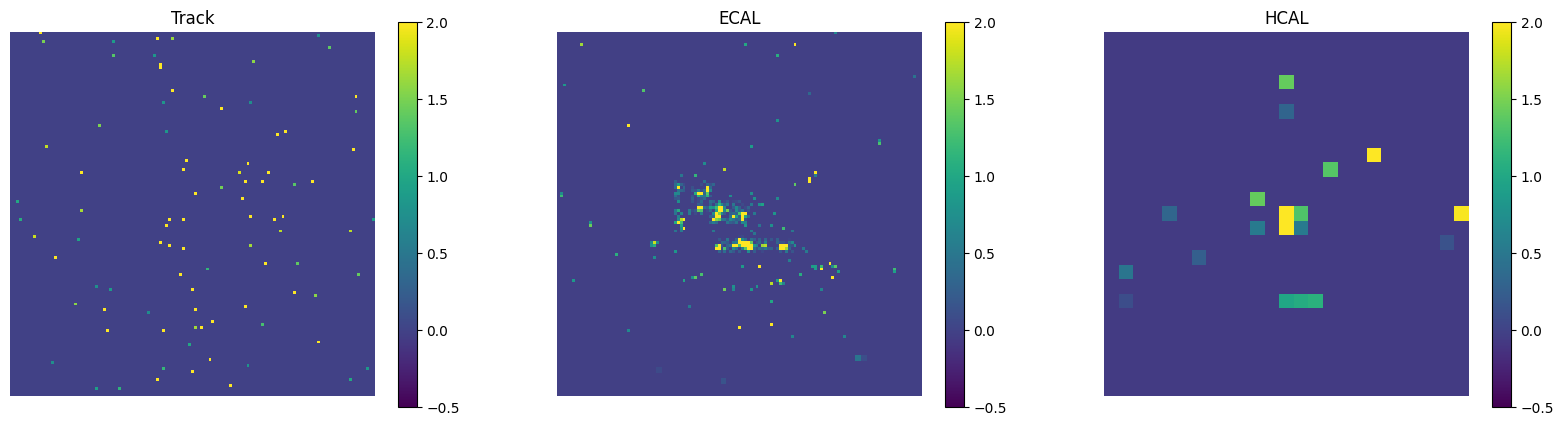

In [37]:
# Display original images from X_jets
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 20))
ls = ['Track','ECAL','HCAL']
for i in range(3):
    temp = axes[i].imshow(X_train_normalized[0,:,:,i], cmap='viridis', vmin=-0.5, vmax=2.0, interpolation='nearest')
    axes[i].axis('off')
    axes[i].set_title('{}'.format(ls[i]))
    fig.colorbar(temp, ax=axes[i], shrink=0.25)

In [38]:
class jet_dataset(Dataset):
    def __init__(self,X,y,mode='train',transforms=None):
        self.X = X
        self.y = y
        self.transforms=transforms
    def __len__(self):
        return len(self.y)
    def __getitem__(self,idx):
        img = self.X[idx]
        if self.transforms:
            img = self.transforms(img)
        return {'X':img,'y':self.y[idx]}

In [39]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x:(x*2)-1), # Scale Between [-1,1]
    transforms.Resize((128,128)),
])
val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x:(x*2)-1) # Scale Between [-1,1]
])
train_dataset = jet_dataset(X_train_normalized,y_train,mode='train',transforms=train_transforms)
val_dataset = jet_dataset(X_val_normalized,y_val,mode='val',transforms=val_transforms)
train_loader = DataLoader(train_dataset,batch_size=CFG.train_batch_size,shuffle=False,drop_last=True)
val_loader = DataLoader(val_dataset,batch_size=CFG.val_batch_size,shuffle=False,drop_last=True)

# Generate Denoised Images

In [40]:
import torch.nn.functional as F

def cosine_schedule(num_timesteps, s=0.008):
    def f(t):
        return torch.cos((t / num_timesteps + s) / (1 + s) * 0.5 * torch.pi) ** 2
    x = torch.linspace(0, num_timesteps, num_timesteps + 1)
    alphas_cumprod = f(x) / f(torch.tensor([0]))
    betas = 1 - alphas_cumprod[1:] / alphas_cumprod[:-1]
    betas = torch.clip(betas, 0.0001, 0.999)
    return betas
def get_index_from_list(vals, t, x_shape):
    """ 
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """ 
    Takes an image and a timestep as input and 
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


# Define beta schedule
T = 200
betas = cosine_schedule(num_timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

/tmp/ipykernel_34/3466931867.py:30: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images+1, math.ceil((idx/stepsize)) + 1)


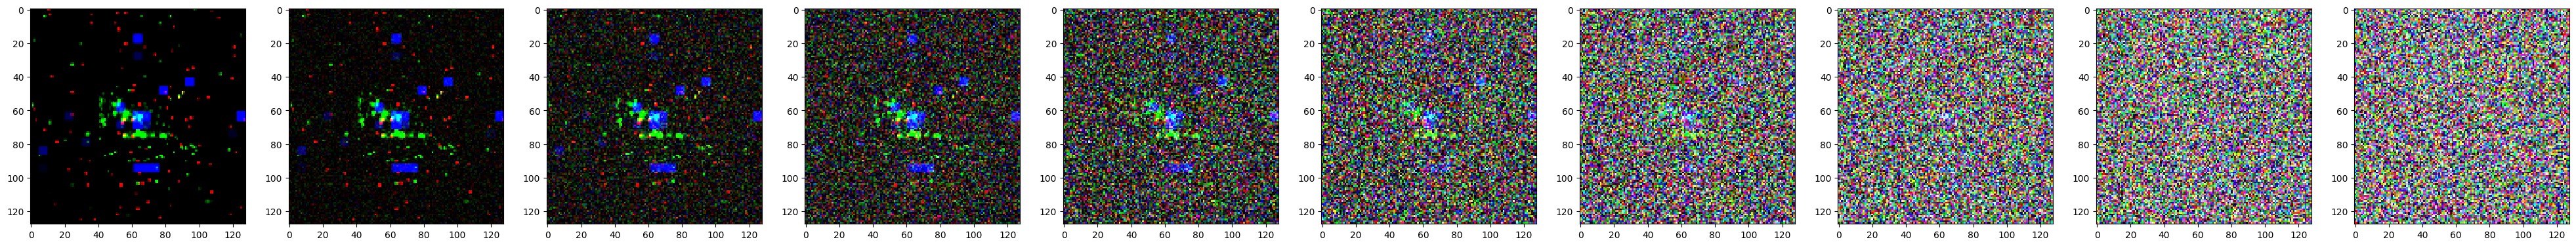

In [41]:
def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),         #Scale from [-1,+1] to [0,1]
        transforms.Lambda(lambda t: t.permute(1, 2, 0)),  # CHW to HWC
        transforms.Lambda(lambda im: np.array(im)),       # convert to NumPy array
    ])
    
    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    # image = reverse_transforms(combined)
    image = reverse_transforms(image)
    #plt.imshow(image[:,:,0], cmap='viridis', vmin=-0.5, vmax=2.0, interpolation='nearest')
    #plt.imshow(image[:,:,1], cmap='viridis', vmin=-0.5, vmax=2.0, interpolation='nearest')
    plt.imshow(image, cmap='viridis', vmin=-0.5, vmax=2.0, interpolation='nearest')

plt.figure(figsize=(55,55))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

# Simulate forward diffusion
image = next(iter(train_loader))['X'][0]

# print(image.type)
show_tensor_image(image)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, math.ceil((idx/stepsize)) + 1)
    #show_tensor_image(image)
    image, noise = forward_diffusion_sample(image, t)
    show_tensor_image(image)

# UNET

In [42]:
from torch import nn
import math


class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        
    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings


class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 3 
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        
        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])
        
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels

            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        return self.output(x)

model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  62438883


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transfor

# Loss

In [43]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns 
    the denoised image. 
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

@torch.no_grad()
def sample_plot_image():
    # Sample noise
    img_size = 128
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            show_tensor_image(img.detach().cpu())
    plt.show()            

0it [00:00, ?it/s]

Epoch 0 | step 000 Loss: 0.8081783056259155 


/tmp/ipykernel_34/130810024.py:48: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images, int(i/stepsize)+1)


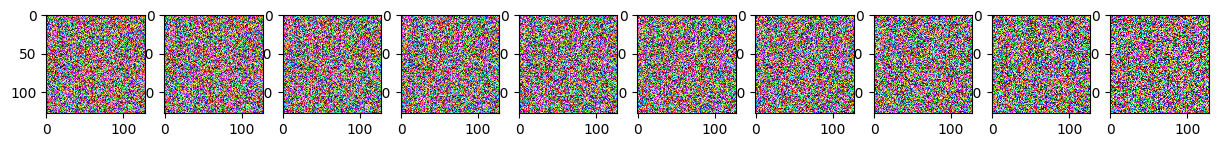

125it [01:47,  1.17it/s]
0it [00:00, ?it/s]

Epoch 1 | step 000 Loss: 0.3603350520133972 


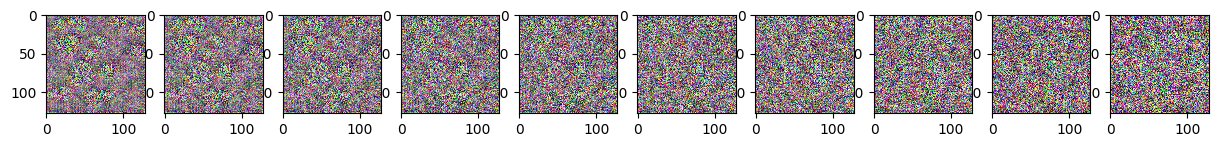

125it [01:47,  1.16it/s]
0it [00:00, ?it/s]

Epoch 2 | step 000 Loss: 0.19968780875205994 


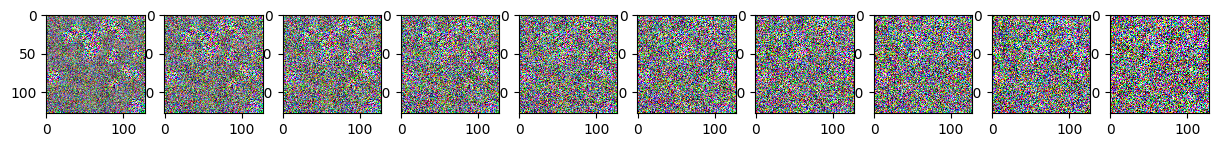

125it [01:47,  1.16it/s]
0it [00:00, ?it/s]

Epoch 3 | step 000 Loss: 0.21021758019924164 


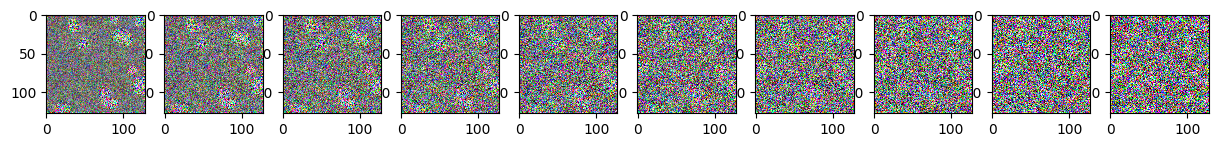

125it [01:47,  1.16it/s]
0it [00:00, ?it/s]

Epoch 4 | step 000 Loss: 0.19611570239067078 


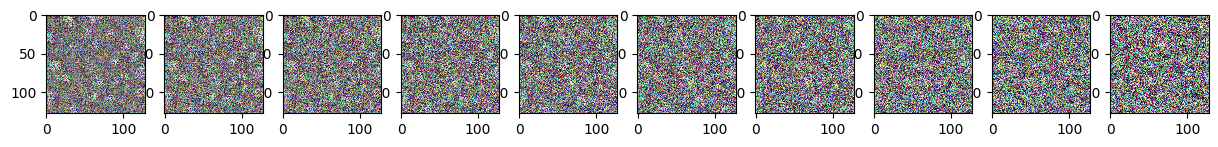

125it [01:47,  1.16it/s]
0it [00:00, ?it/s]

Epoch 5 | step 000 Loss: 0.18897104263305664 


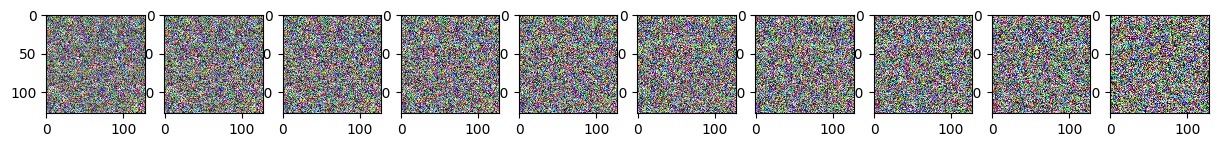

125it [01:47,  1.16it/s]
0it [00:00, ?it/s]

Epoch 6 | step 000 Loss: 0.16292104125022888 


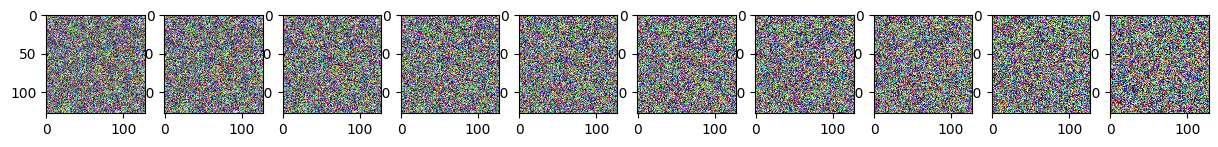

125it [01:47,  1.16it/s]
0it [00:00, ?it/s]

Epoch 7 | step 000 Loss: 0.1788288801908493 


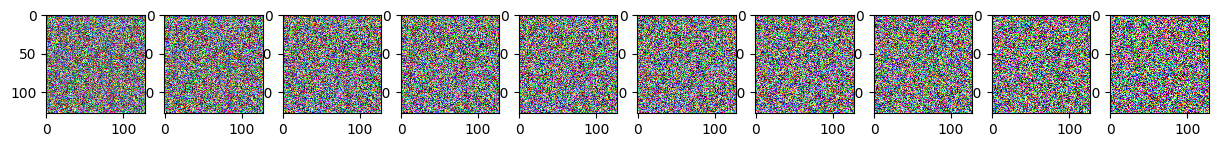

125it [01:47,  1.16it/s]
0it [00:00, ?it/s]

Epoch 8 | step 000 Loss: 0.1275191456079483 


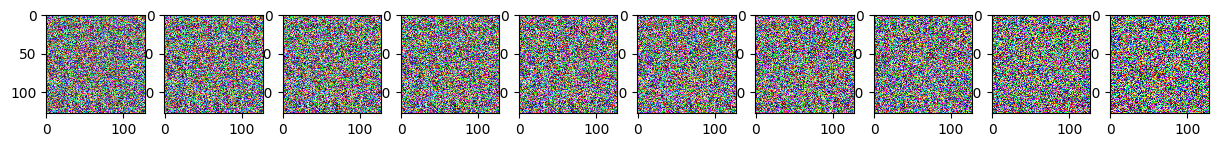

125it [01:47,  1.16it/s]
0it [00:00, ?it/s]

Epoch 9 | step 000 Loss: 0.12293937057256699 


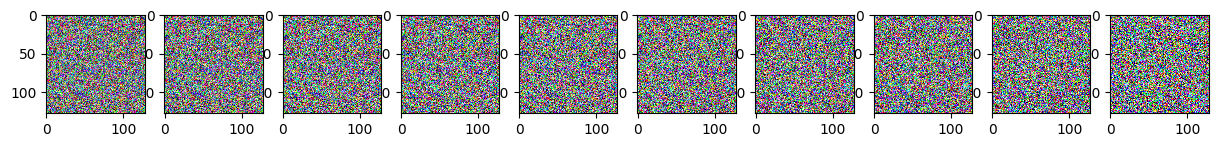

125it [01:47,  1.16it/s]
0it [00:00, ?it/s]

Epoch 10 | step 000 Loss: 0.14509031176567078 


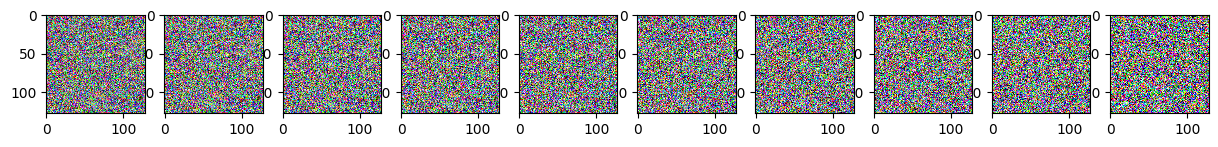

125it [01:48,  1.16it/s]
0it [00:00, ?it/s]

Epoch 11 | step 000 Loss: 0.14789500832557678 


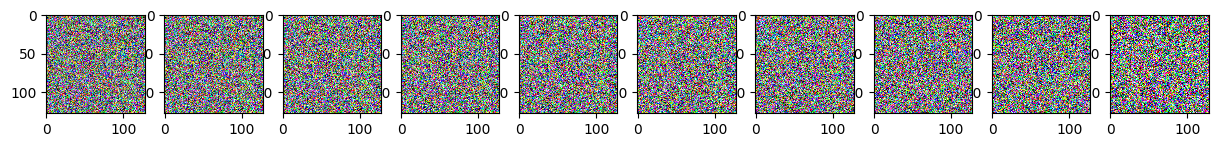

125it [01:47,  1.16it/s]
0it [00:00, ?it/s]

Epoch 12 | step 000 Loss: 0.10729271173477173 


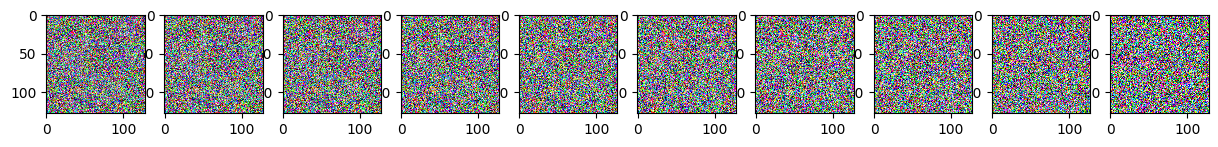

125it [01:47,  1.16it/s]
0it [00:00, ?it/s]

Epoch 13 | step 000 Loss: 0.13546936213970184 


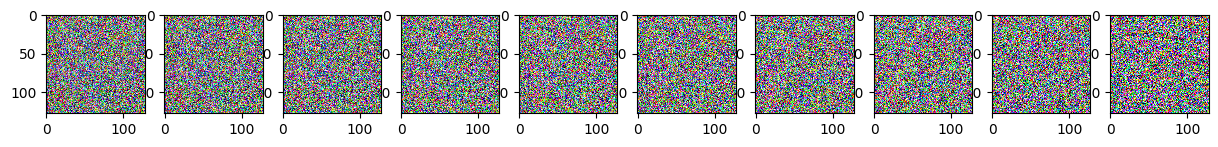

125it [01:47,  1.16it/s]
0it [00:00, ?it/s]

Epoch 14 | step 000 Loss: 0.13492068648338318 


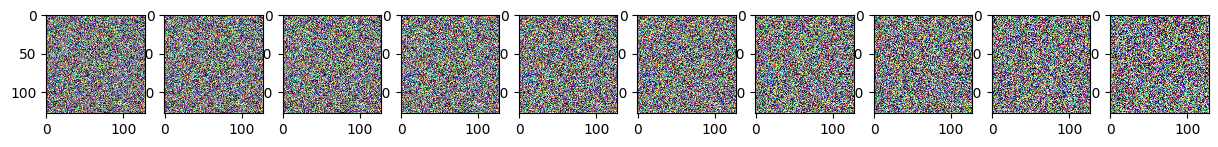

125it [01:47,  1.16it/s]
0it [00:00, ?it/s]

Epoch 15 | step 000 Loss: 0.10277658700942993 


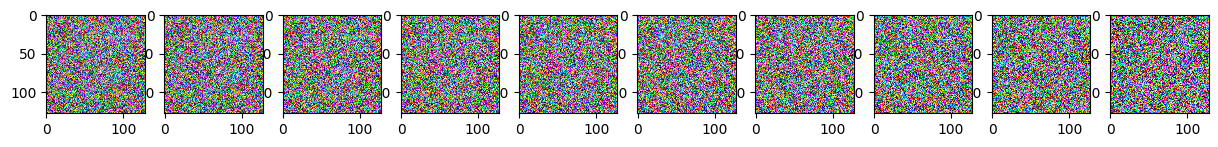

125it [01:47,  1.16it/s]
0it [00:00, ?it/s]

Epoch 16 | step 000 Loss: 0.11239485442638397 


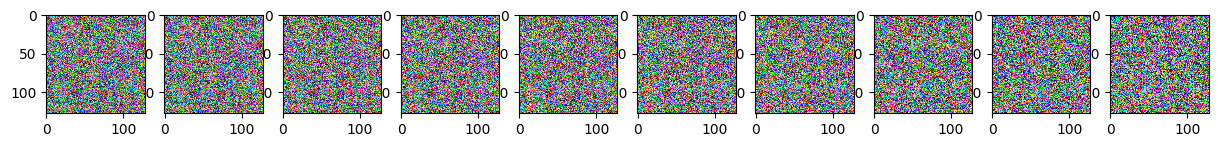

125it [01:47,  1.16it/s]
0it [00:00, ?it/s]

Epoch 17 | step 000 Loss: 0.10471315681934357 


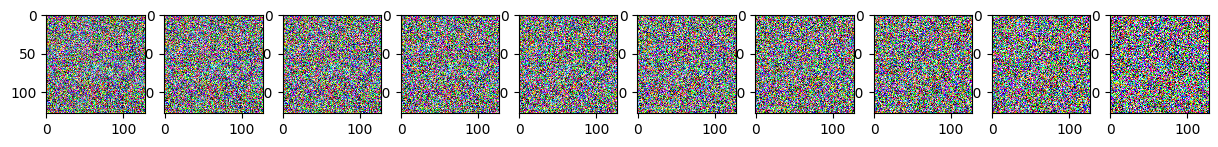

101it [01:28,  1.14it/s]


KeyboardInterrupt: 

In [44]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = AdamW(model.parameters(), lr=0.00005)
epochs = CFG.nepochs
logs = {}
logs['Loss'] = []
for epoch in range(epochs):
    a=0
    for step, batch in tqdm(enumerate(train_loader)):
        optimizer.zero_grad()
        t = torch.randint(0, T, (CFG.train_batch_size,), device=device).long()
        loss = get_loss(model, batch['X'], t)
        loss.backward()
        optimizer.step()
        logs['Loss'].append(loss.detach().cpu().item())
        if step == 0:
            print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
            sample_plot_image()

# Discussion
- Performance of a diffusion model is dependent on scheduler choice and range
- Experimentation with the above may improve the performance
- Sparsity makes the learning hard
- Since the data is Raw physical data, preprocessing is to be choosen properly